### SHL github project: uat_shl

* training module: shl_tm

* prediction module: shl_pm

* simulation module: shl_sm

* misc module: shl_mm


### data feeds:

* historical bidding price, per second, time series

* live bidding price, per second, time series

### parameter lookup table: python dictionary

* parm_si (seasonality index per second)

* parm_month (parameter like alpha, beta, gamma, etc. per month)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

### Read raw data

In [3]:
df_history_ts_process = pd.read_csv('data/history_ts.csv') 
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,ref-price
1886,2017-07,11:29:56,92100,89800
1887,2017-07,11:29:57,92100,89800
1888,2017-07,11:29:58,92100,89800
1889,2017-07,11:29:59,92200,89800
1890,2017-07,11:30:00,92200,89800


In [4]:
df_history_table_process = pd.read_csv('data/history_table.csv') 
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder
26,2017-03,10356,87800,87916,55,262010
27,2017-04,12196,89800,89850,59,252273
28,2017-05,10316,90100,90209,55,270197
29,2017-06,10312,89400,89532,45,244349
30,2017-07,10325,92200,92250,57,269189


In [5]:
df_parm_si = pd.read_csv('data/parm_si.csv') 
# print(df_parm_si[(df_parm_si['ccyy-mm'] == '2017-07') & (df_parm_si['time'] == '11:29:00')].iloc[0]['si'])
df_parm_si.tail()

,ccyy-mm,time,si
2191,2017-12,11:29:56,1.0
2192,2017-12,11:29:57,1.0
2193,2017-12,11:29:58,1.0
2194,2017-12,11:29:59,1.0
2195,2017-12,11:30:00,1.0


In [6]:
df_parm_month = pd.read_csv('data/parm_month.csv') 
# print(df_parm_month[(df_parm_month['ccyy-mm'] == '2017-07') & (df_parm_month['time'] == '11:29:00')].iloc[0]['di'])
df_parm_month.tail()

,ccyy-mm,time,alpha,beta,gamma,sec57-weight,month-weight,short-weight,direction,di
67,2020-08,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
68,2020-09,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
69,2020-10,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
70,2020-11,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
71,2020-12,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300


# Initialization

In [7]:
# function to fetch Seasonality-Index
def fetech_si(ccyy_mm, time, df_parm_si):
#     return df_parm_si[(df_parm_si['ccyy-mm'] == '2017-09') & (df_parm_si['time'] == '11:29:00')]
    return df_parm_si[(df_parm_si['ccyy-mm'] == ccyy_mm) & (df_parm_si['time'] == time)].iloc[0]['si']


In [8]:
# function to fetch Dynamic-Increment
def fetech_di(ccyy_mm, df_parm_month):
#     print(df_parm_month[df_parm_month['ccyy-mm'] == '2017-07'].iloc[0]['di'])
    return df_parm_month[df_parm_month['ccyy-mm'] == ccyy_mm].iloc[0]['di']


In [9]:
def get_previous_n_sec_time_as_str(df_time_field, n):
    return str((pd.to_datetime(df_time_field, format='%H:%M:%S') - pd.Timedelta(seconds=n)).time())
# print(get_previous_n_sec_time_as_str('11:29:57',3))

def get_future_n_sec_time_as_str(df_time_field, n):
    return str((pd.to_datetime(df_time_field, format='%H:%M:%S') - pd.Timedelta(seconds=-n)).time())
# print(get_future_n_sec_time_as_str('11:29:57',3))

  Global Parameters for Month : 2017-07
-------------------------------------------------
global_parm_dynamic_increment : 300
global_parm_alpha             : 0.642332134767631
global_parm_beta              : 0.230274892614982
global_parm_gamma             : 0.218044289515065
global_parm_sec57_weight      : 0.500000
global_parm_month_weight      : 0.900000
global_parm_short_weight      : 0.125000


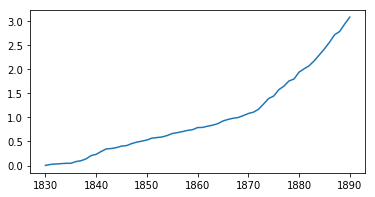

In [19]:
# which month to predict?
global_parm_ccyy_mm = '2017-07' 

# create global base price
global_parm_base_price = 10000000

# create predictino results dataframe: shl_pm
# df_shl_pm = pd.DataFrame()

global_parm_dynamic_increment = fetech_di(global_parm_ccyy_mm, df_parm_month)

global_parm_alpha = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['alpha']
global_parm_beta  = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['beta']
global_parm_gamma = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['gamma']
global_parm_sec57_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['sec57-weight']
global_parm_month_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['month-weight']
global_parm_short_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['short-weight']

global_parm_short_weight_misc = 0

print('=================================================')
print('  Global Parameters for Month : %s' % global_parm_ccyy_mm)
print('-------------------------------------------------')

print('global_parm_dynamic_increment : %d' % global_parm_dynamic_increment)

print('global_parm_alpha             : %0.15f' % global_parm_alpha) # used in forecasting
print('global_parm_beta              : %0.15f' % global_parm_beta)  # used in forecasting
print('global_parm_gamma             : %0.15f' % global_parm_gamma) # used in forecasting
print('global_parm_sec57_weight      : %f' % global_parm_sec57_weight) # used in training a model
print('global_parm_month_weight      : %f' % global_parm_month_weight) # used in training a model
print('global_parm_short_weight      : %f' % global_parm_short_weight) # used in training a model
print('=================================================')

# plot seasonality index
# print(df_parm_si[(df_parm_si['ccyy-mm'] == '2017-07')]['si'])
plt.figure(figsize=(6,3))
plt.plot(df_parm_si[(df_parm_si['ccyy-mm'] == '2017-07')]['si'])


# Start of shl_sm

In [25]:
# 11:29:00~11:29:50

global_parm_short_weight_misc = 0

for i in range(1830, 1830+51): # use July 2015 data as simulatino
    print('\n<<<< Record No.: %5d >>>>' % i)
    print(df_history_ts_process['ccyy-mm'][i]) # format: ccyy-mm
    print(df_history_ts_process['time'][i]) # format: hh:mm:ss
    print(df_history_ts_process['bid-price'][i]) # format: integer
#     print(df_history_ts_process['ref-price'][i])
    
    # capture & calculate 11:29:00 bid price - 1 = base price
    if df_history_ts_process['time'][i] == '11:29:00':
        global_parm_base_price = df_history_ts_process['bid-price'][i] -1 
        print('#### global_parm_base_price : %d ####' % global_parm_base_price)

        
    print('---- Pre-Process ---')
    # pre-process: ccyy-mm-hh:mm:ss
    f_actual_datetime = df_history_ts_process['ccyy-mm'][i] + ' ' + df_history_ts_process['time'][i]
    f_actual_price4pm = df_history_ts_process['bid-price'][i] -  global_parm_base_price
    print('#### f_actual_datetime   : %s ####' %  f_actual_datetime)
    print('#### f_actual_price4pm   : %d ####' % f_actual_price4pm)
    
    # get Seasonality-Index
    f_actual_si = fetech_si(df_history_ts_process['ccyy-mm'][i]
                                         ,df_history_ts_process['time'][i]
                                         ,df_parm_si)
    print('#### f_actual_si         : %0.10f ####' %  f_actual_si)
    f_1_step_si = fetech_si(df_history_ts_process['ccyy-mm'][i]
                                         ,df_history_ts_process['time'][i+1]
                                         ,df_parm_si)
    print('#### f_1_step_si         : %0.10f ####' %  f_1_step_si)
    # get de-seasoned price: price4pmsi
    f_actual_price4pmsi = f_actual_price4pm / f_actual_si
    print('#### f_actual_price4pmsi : %0.10f ####' % f_actual_price4pmsi)
    


    if df_history_ts_process['time'][i] == '11:29:00':
        df_shl_pm = pd.DataFrame() # initialize prediction dataframe at 11:29:00
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        f_1_step_pred_les_level = f_actual_price4pmsi
        f_1_step_pred_les_trend = 0
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        f_1_step_pred_les_misc = 0
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment
        f_current_step_pred_les = f_1_step_pred_les
        f_current_step_pred_les_misc = f_1_step_pred_les_misc
        f_current_step_pred_price_inc = f_1_step_pred_price_inc
        f_current_step_pred_price = f_1_step_pred_price
        f_current_step_pred_price_rounded = f_1_step_pred_price_rounded
        f_current_step_pred_dynamic_increment = f_1_step_pred_dynamic_increment # +200 or + 300
        f_current_step_pred_set_price_rounded = f_1_step_pred_set_price_rounded
        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
    else:
        previous_time = get_previous_n_sec_time_as_str(df_history_ts_process['time'][i], 1)
        previous_pred_les_level = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_level']
        print('     previous_pred_les_level : %f' % previous_pred_les_level)
        
        previous_pred_les_trend = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_trend']
        print('     previous_pred_les_trend : %f' % previous_pred_les_trend)
        
        f_current_step_pred_les = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les']
        f_current_step_pred_les_misc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_misc']
        f_current_step_pred_price_inc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_inc']
        f_current_step_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price']
        f_current_step_pred_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_rounded']
        f_current_step_pred_dynamic_increment = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_dynamic_increment']
        f_current_step_pred_set_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_set_price_rounded']

        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
            
        if df_history_ts_process['time'][i] == '11:29:50':
            # function to get average forecast error between 46~50 seconds: mean(f_current_step_error)
            global_parm_short_weight_misc = (df_shl_pm.iloc[46:50]['f_current_step_error'].sum() \
                                             + f_current_step_error) / 5
            print('     global_parm_short_weight_misc : %f' % global_parm_short_weight_misc)
            
#         call predicitno functino shl_pm, forcaste next k=1 step
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        
        f_1_step_pred_les_level = global_parm_alpha * f_actual_price4pmsi \
                                    + (1 - global_parm_alpha) * (previous_pred_les_level + previous_pred_les_trend)
        print('     f_1_step_pred_les_level  : %f' % f_1_step_pred_les_level)
        f_1_step_pred_les_trend = global_parm_beta * (f_1_step_pred_les_level - previous_pred_les_level) \
                                    + (1 - global_parm_beta) * previous_pred_les_trend
        print('     f_1_step_pred_les_trend  : %f' % f_1_step_pred_les_trend)
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        
        f_1_step_pred_les_misc = global_parm_short_weight_misc * global_parm_short_weight * global_parm_gamma
        
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment
   
        
    # write results to shl_pm dataframe
            
    df_shl_pm_current = {
                         'ccyy-mm' : df_history_ts_process['ccyy-mm'][i]
                        ,'time' : df_history_ts_process['time'][i]
                        ,'bid' : df_history_ts_process['bid-price'][i]
                        ,'datetime' : f_actual_datetime
                        ,'f_actual_price4pm' : f_actual_price4pm
                        ,'f_actual_si' : f_actual_si
                        ,'f_1_step_si' : f_1_step_si
                        ,'f_actual_price4pmsi' :  f_actual_price4pmsi
                        ,'f_1_step_pred_les_level' : f_1_step_pred_les_level
                        ,'f_1_step_pred_les_trend' : f_1_step_pred_les_trend
                        ,'f_1_step_pred_les' : f_1_step_pred_les
                        ,'f_1_step_pred_les_misc' : f_1_step_pred_les_misc
                        ,'f_1_step_pred_price_inc' : f_1_step_pred_price_inc
                        ,'f_1_step_pred_price' : f_1_step_pred_price
                        ,'f_1_step_pred_price_rounded' : f_1_step_pred_price_rounded
                        ,'f_1_step_pred_dynamic_increment' : f_1_step_pred_dynamic_increment # +200 or + 300
                        ,'f_1_step_pred_set_price_rounded' : f_1_step_pred_set_price_rounded
                        ,'f_current_step_pred_les' : f_current_step_pred_les
                        ,'f_current_step_pred_les_misc' : f_current_step_pred_les_misc
                        ,'f_current_step_pred_price_inc' : f_current_step_pred_price_inc
                        ,'f_current_step_pred_price' : f_current_step_pred_price
                        ,'f_current_step_pred_price_rounded' : f_current_step_pred_price_rounded
                        ,'f_current_step_pred_dynamic_increment' : f_current_step_pred_dynamic_increment # +200 or + 300
                        ,'f_current_step_pred_set_price_rounded' : f_current_step_pred_set_price_rounded
                        ,'f_current_step_error' : f_current_step_error
                        }
    df_shl_pm =  df_shl_pm.append(df_shl_pm_current, ignore_index=True)



<<<< Record No.:  1830 >>>>
2017-07
11:29:00
90400
#### global_parm_base_price : 90399 ####
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:00 ####
#### f_actual_price4pm   : 1 ####
#### f_actual_si         : 0.0023669570 ####
#### f_1_step_si         : 0.0223882810 ####
#### f_actual_price4pmsi : 422.4833826724 ####
---- call predicitno function shl_pm ---- 11:29:00

<<<< Record No.:  1831 >>>>
2017-07
11:29:01
90400
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:01 ####
#### f_actual_price4pm   : 1 ####
#### f_actual_si         : 0.0223882810 ####
#### f_1_step_si         : 0.0309107700 ####
#### f_actual_price4pmsi : 44.6662251559 ####
     previous_pred_les_level : 422.483383
     previous_pred_les_trend : 0.000000
---- call predicitno function shl_pm ---- 11:29:01
     f_1_step_pred_les_level  : 179.799281
     f_1_step_pred_les_trend  : -55.884055

<<<< Record No.:  1832 >>>>
2017-07
11:29:02
90400
---- Pre-Process ---
#### f_actual_datetime   : 2017

---- call predicitno function shl_pm ---- 11:29:17
     f_1_step_pred_les_level  : 694.702008
     f_1_step_pred_les_trend  : 56.605249

<<<< Record No.:  1848 >>>>
2017-07
11:29:18
90700
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:18 ####
#### f_actual_price4pm   : 301 ####
#### f_actual_si         : 0.4836754840 ####
#### f_1_step_si         : 0.5045423610 ####
#### f_actual_price4pmsi : 622.3180830062 ####
     previous_pred_les_level : 694.702008
     previous_pred_les_trend : 56.605249
---- call predicitno function shl_pm ---- 11:29:18
     f_1_step_pred_les_level  : 668.453366
     f_1_step_pred_les_trend  : 37.526078

<<<< Record No.:  1849 >>>>
2017-07
11:29:19
90700
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:19 ####
#### f_actual_price4pm   : 301 ####
#### f_actual_si         : 0.5045423610 ####
#### f_1_step_si         : 0.5273150370 ####
#### f_actual_price4pmsi : 596.5802344196 ####
     previous_pred_les_level : 668.453366
     previous

11:29:34
90700
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:34 ####
#### f_actual_price4pm   : 301 ####
#### f_actual_si         : 0.8670445380 ####
#### f_1_step_si         : 0.9216129500 ####
#### f_actual_price4pmsi : 347.1563302784 ####
     previous_pred_les_level : 358.261819
     previous_pred_les_trend : -12.105285
---- call predicitno function shl_pm ---- 11:29:34
     f_1_step_pred_les_level  : 346.798735
     f_1_step_pred_les_trend  : -11.957402

<<<< Record No.:  1865 >>>>
2017-07
11:29:35
90800
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:35 ####
#### f_actual_price4pm   : 401 ####
#### f_actual_si         : 0.9216129500 ####
#### f_1_step_si         : 0.9539289700 ####
#### f_actual_price4pmsi : 435.1067332550 ####
     previous_pred_les_level : 346.798735
     previous_pred_les_trend : -11.957402
---- call predicitno function shl_pm ---- 11:29:35
     f_1_step_pred_les_level  : 399.245022
     f_1_step_pred_les_trend  : 2.873150

<<<< R

     previous_pred_les_level : 563.334921
     previous_pred_les_trend : 9.180447
     global_parm_short_weight_misc : -30.903012
---- call predicitno function shl_pm ---- 11:29:50
     f_1_step_pred_les_level  : 570.643404
     f_1_step_pred_les_trend  : 8.749380


In [26]:
# df_shl_pm.iloc[2]
df_shl_pm.head()

,bid,ccyy-mm,datetime,f_1_step_pred_dynamic_increment,f_1_step_pred_les,f_1_step_pred_les_level,f_1_step_pred_les_misc,f_1_step_pred_les_trend,f_1_step_pred_price,f_1_step_pred_price_inc,...,f_actual_si,f_current_step_error,f_current_step_pred_dynamic_increment,f_current_step_pred_les,f_current_step_pred_les_misc,f_current_step_pred_price,f_current_step_pred_price_inc,f_current_step_pred_price_rounded,f_current_step_pred_set_price_rounded,time
0,90400.0,2017-07,2017-07 11:29:00,300.0,422.483383,422.483383,0.0,0.000000,90408.458677,9.458677,...,0.002367,8.458677,300.0,422.483383,0.0,90408.458677,9.458677,90400.0,90700.0,11:29:00
1,90400.0,2017-07,2017-07 11:29:01,300.0,123.915226,179.799281,0.0,-55.884055,90402.830315,3.830315,...,0.022388,8.458677,300.0,422.483383,0.0,90408.458677,9.458677,90400.0,90700.0,11:29:01
2,90400.0,2017-07,2017-07 11:29:02,300.0,-4.326865,65.100699,0.0,-69.427564,90398.836576,-0.163424,...,0.030911,2.830315,300.0,123.915226,0.0,90402.830315,3.830315,90400.0,90700.0,11:29:02
3,90400.0,2017-07,2017-07 11:29:03,300.0,-49.412365,15.459009,0.0,-64.871374,90396.741597,-2.258403,...,0.037770,-1.163424,300.0,-4.326865,0.0,90398.836576,-0.163424,90400.0,90700.0,11:29:03
4,90400.0,2017-07,2017-07 11:29:04,300.0,-57.945823,-3.619416,0.0,-54.326408,90396.376219,-2.623781,...,0.045705,-3.258403,300.0,-49.412365,0.0,90396.741597,-2.258403,90400.0,90700.0,11:29:04


In [28]:
df_shl_pm.tail()

,bid,ccyy-mm,datetime,f_1_step_pred_dynamic_increment,f_1_step_pred_les,f_1_step_pred_les_level,f_1_step_pred_les_misc,f_1_step_pred_les_trend,f_1_step_pred_price,f_1_step_pred_price_inc,...,f_actual_si,f_current_step_error,f_current_step_pred_dynamic_increment,f_current_step_pred_les,f_current_step_pred_les_misc,f_current_step_pred_price,f_current_step_pred_price_inc,f_current_step_pred_price_rounded,f_current_step_pred_set_price_rounded,time
46,91200.0,2017-07,2017-07 11:29:46,300.0,500.214563,501.770041,0.000000,-1.555478,91220.047697,821.047697,...,1.568621,-38.899666,300.0,485.841075,0.0,91161.100334,762.100334,91200.0,91500.0,11:29:46
47,91300.0,2017-07,2017-07 11:29:47,300.0,537.151994,531.502619,0.000000,5.649376,91338.517127,939.517127,...,1.641391,-79.952303,300.0,500.214563,0.0,91220.047697,821.047697,91200.0,91500.0,11:29:47
48,91400.0,2017-07,2017-07 11:29:48,300.0,570.579848,559.731077,0.000000,10.848771,91420.186593,1021.186593,...,1.749071,-61.482873,300.0,537.151994,0.0,91338.517127,939.517127,91300.0,91600.0,11:29:48
49,91400.0,2017-07,2017-07 11:29:49,300.0,572.515368,563.334921,0.000000,9.180447,91505.633188,1106.633188,...,1.789735,20.186593,300.0,570.579848,0.0,91420.186593,1021.186593,91400.0,91700.0,11:29:49
50,91500.0,2017-07,2017-07 11:29:50,300.0,579.392785,570.643404,-0.842278,8.749380,91556.786752,1157.786752,...,1.932932,5.633188,300.0,572.515368,0.0,91505.633188,1106.633188,91500.0,91800.0,11:29:50


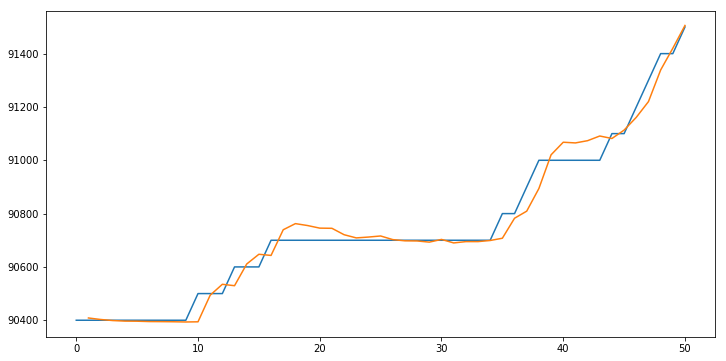

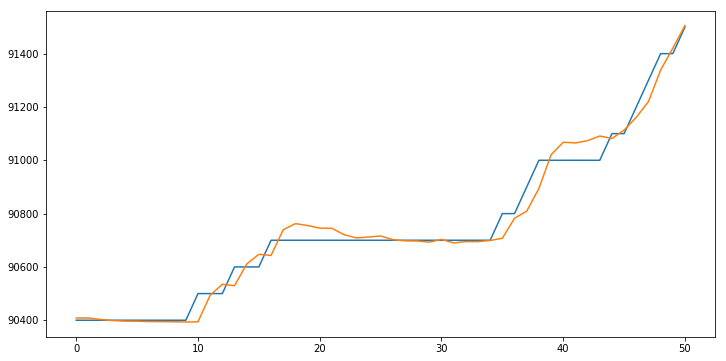

In [29]:
plt.figure(figsize=(12,6))
plt.plot(df_shl_pm['bid'])
# plt.plot(df_shl_pm['pred_price'])
plt.plot(df_shl_pm['f_1_step_pred_price'].shift(1))
# plt.plot(df_shl_pm['pred_price'].shift(-1))

plt.figure(figsize=(12,6))
plt.plot(df_shl_pm['bid'])
# plt.plot(df_shl_pm['pred_price'])
plt.plot(df_shl_pm['f_current_step_pred_price'])
# plt.plot(df_shl_pm['pred_price'].shift(-1))


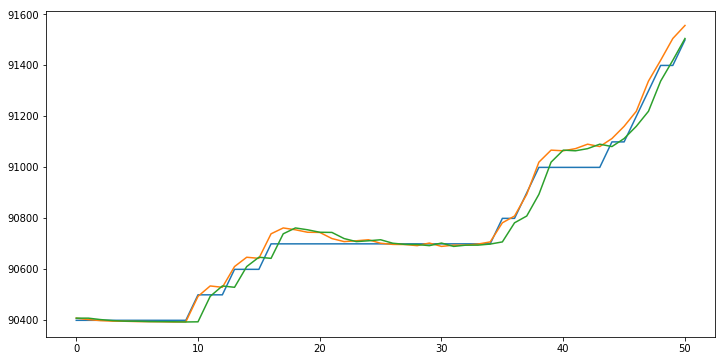

In [30]:

plt.figure(figsize=(12,6))
plt.plot(df_shl_pm['bid'])
plt.plot(df_shl_pm['f_1_step_pred_price'])
plt.plot(df_shl_pm['f_current_step_pred_price'])


### Start of prediction module: shl_pm

In [31]:
# 11:29:51~
def predict_k_step_price(df_shl_pm, ccyy_mm, time, k):
    print('month & time  : ', ccyy_mm, time)
    print()
    
#     df_shl_pm_k = pd.DataFrame() # initialize prediction dataframe
    for sec in range(0, k):
        
        
        print('delta second(s) : ', sec)
        current_time  = get_future_n_sec_time_as_str(time, sec)
        print('current_time  : %s' % current_time)
        f_1_step_time  = get_future_n_sec_time_as_str(current_time, 1)
        print('f_1_step_time  : %s' % f_1_step_time)
        previous_time = get_previous_n_sec_time_as_str(current_time, 1)
        print('previous_time : %s' % previous_time)

        previous_pred_les_level = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_level']
        print('     previous_pred_les_level : %f' % previous_pred_les_level)
        
        previous_pred_les_trend = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_trend']
        print('     previous_pred_les_trend : %f' % previous_pred_les_trend)


        print('---- Pre-Process ---')
        ############ use predicted value for boost-trap
        previous_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] == previous_time)].iloc[0]['f_1_step_pred_price']
        # pre-process: ccyy-mm-hh:mm:ss
        f_actual_datetime = global_parm_ccyy_mm + ' ' + current_time
#         f_actual_price4pm = df_history_ts_process['bid-price'][i] -  global_parm_base_price
        f_actual_price4pm = previous_pred_price -  global_parm_base_price
        print('#### f_actual_datetime   : %s ####' %  f_actual_datetime)
        print('#### previous_pred_price: %s ####' %  previous_pred_price)
        print('#### f_actual_price4pm   : %d ####' % f_actual_price4pm)

        # get Seasonality-Index
        f_actual_si = fetech_si(global_parm_ccyy_mm
                                             ,current_time
                                             ,df_parm_si)
        try:
            f_1_step_si = fetech_si(global_parm_ccyy_mm
                                                 ,f_1_step_time
                                                 ,df_parm_si)
        except:
            f_1_step_si = fetech_si(global_parm_ccyy_mm
                                                 ,current_time
                                                 ,df_parm_si)            

        print('#### f_actual_si         : %0.10f ####' %  f_actual_si)
        # get de-seasoned price: price4pmsi
        f_actual_price4pmsi = f_actual_price4pm / f_actual_si
        print('#### f_actual_price4pmsi : %0.10f ####' % f_actual_price4pmsi)

        f_current_step_pred_les = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les']
        f_current_step_pred_les_misc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_misc']
        f_current_step_pred_price_inc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_inc']
        f_current_step_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price']
        f_current_step_pred_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_rounded']
        f_current_step_pred_dynamic_increment = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_dynamic_increment']
        f_current_step_pred_set_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_set_price_rounded']
        
        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
        

        f_1_step_pred_les_level = global_parm_alpha * f_actual_price4pmsi \
                                    + (1 - global_parm_alpha) * (previous_pred_les_level + previous_pred_les_trend)
        print('     f_1_step_pred_les_level  : %f' % f_1_step_pred_les_level)
        f_1_step_pred_les_trend = global_parm_beta * (f_1_step_pred_les_level - previous_pred_les_level) \
                                    + (1 - global_parm_beta) * previous_pred_les_trend
        print('     f_1_step_pred_les_trend  : %f' % f_1_step_pred_les_trend)
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        
#         f_1_step_pred_les_misc = 0
        f_1_step_pred_les_misc = global_parm_short_weight_misc * global_parm_short_weight * (sec+2) * global_parm_gamma
        
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment 

#         write results to shl_pm dataframe
        df_shl_pm_current = {
                             'ccyy-mm' : global_parm_ccyy_mm
                            ,'time' : current_time
                            ,'bid' : previous_pred_price
                            ,'datetime' : f_actual_datetime
                            ,'f_actual_price4pm' : f_actual_price4pm
                            ,'f_actual_si' : f_actual_si
                            ,'f_1_step_si' : f_1_step_si
                            ,'f_actual_price4pmsi' :  f_actual_price4pmsi
                            ,'f_1_step_pred_les_level' : f_1_step_pred_les_level
                            ,'f_1_step_pred_les_trend' : f_1_step_pred_les_trend
                            ,'f_1_step_pred_les' : f_1_step_pred_les
                            ,'f_1_step_pred_les_misc' : f_1_step_pred_les_misc
                            ,'f_1_step_pred_price_inc' : f_1_step_pred_price_inc
                            ,'f_1_step_pred_price' : f_1_step_pred_price
                            ,'f_1_step_pred_price_rounded' : f_1_step_pred_price_rounded
                            ,'f_1_step_pred_dynamic_increment' : f_1_step_pred_dynamic_increment # +200 or + 300
                            ,'f_1_step_pred_set_price_rounded' : f_1_step_pred_set_price_rounded
                            ,'f_current_step_pred_les' : f_current_step_pred_les
                            ,'f_current_step_pred_les_misc' : f_current_step_pred_les_misc
                            ,'f_current_step_pred_price_inc' : f_current_step_pred_price_inc
                            ,'f_current_step_pred_price' : f_current_step_pred_price
                            ,'f_current_step_pred_price_rounded' : f_current_step_pred_price_rounded
                            ,'f_current_step_pred_dynamic_increment' : f_current_step_pred_dynamic_increment # +200 or + 300
                            ,'f_current_step_pred_set_price_rounded' : f_current_step_pred_set_price_rounded
                            ,'f_current_step_error' : f_current_step_error
                            }
        print('---------------------------')
        df_shl_pm =  df_shl_pm.append(df_shl_pm_current, ignore_index=True)
        
    return df_shl_pm

In [32]:
df_shl_pm_k_step = predict_k_step_price(df_shl_pm, global_parm_ccyy_mm, '11:29:51', 10)

month & time  :  2017-07 11:29:51

delta second(s) :  0
current_time  : 11:29:51
f_1_step_time  : 11:29:52
previous_time : 11:29:50
     previous_pred_les_level : 570.643404
     previous_pred_les_trend : 8.749380
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:51 ####
#### previous_pred_price: 91556.7867519 ####
#### f_actual_price4pm   : 1157 ####
#### f_actual_si         : 2.0011852710 ####
#### f_actual_price4pmsi : 578.5505063630 ####
     f_1_step_pred_les_level  : 578.851762
     f_1_step_pred_les_trend  : 8.624797
---------------------------
delta second(s) :  1
current_time  : 11:29:52
f_1_step_time  : 11:29:53
previous_time : 11:29:51
     previous_pred_les_level : 578.851762
     previous_pred_les_trend : 8.624797
---- Pre-Process ---
#### f_actual_datetime   : 2017-07 11:29:52 ####
#### previous_pred_price: 91609.3069691 ####
#### f_actual_price4pm   : 1210 ####
#### f_actual_si         : 2.0661036070 ####
#### f_actual_price4pmsi : 585.7920023973 ####
     f_

In [33]:
df_shl_pm_k_step['f_actual_si'].tail()

56    2.550697
57    2.705391
58    2.774549
59    2.929183
60    3.071042
Name: f_actual_si, dtype: float64

In [34]:
df_shl_pm_k_step['f_1_step_si'].tail()

56    2.705391
57    2.774549
58    2.929183
59    3.071042
60    3.071042
Name: f_1_step_si, dtype: float64

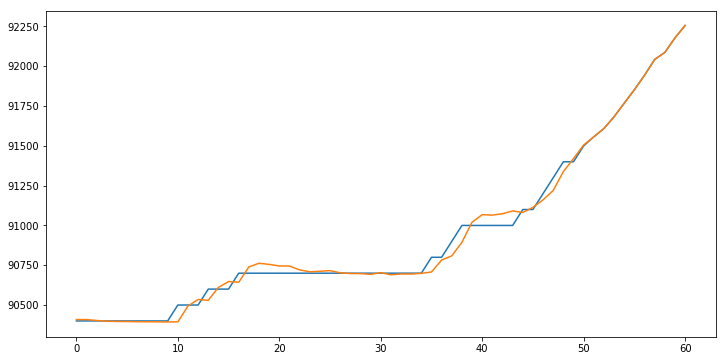

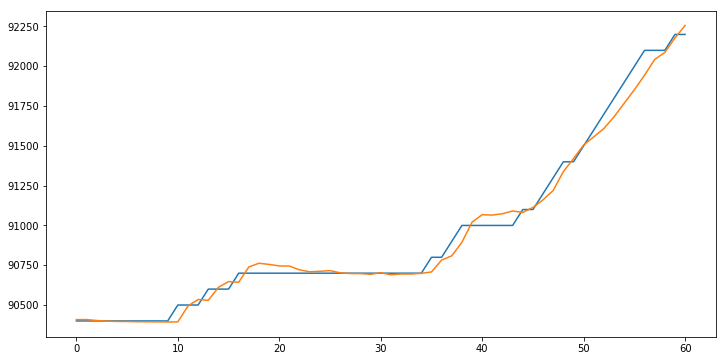

In [35]:
plt.figure(figsize=(12,6))
plt.plot(df_shl_pm_k_step['bid'])
# plt.plot(df_shl_pm_k_step['f_1_step_pred_price'].shift(1))
plt.plot(df_shl_pm_k_step['f_current_step_pred_price'])

df_actual_bid = df_history_ts_process[1830:1830+61].copy()
df_actual_bid.reset_index(inplace=True)
plt.figure(figsize=(12,6))
plt.plot(df_actual_bid['bid-price'])
# plt.plot(df_shl_pm_k_step['f_1_step_pred_price'].shift(1))
plt.plot(df_shl_pm_k_step['f_current_step_pred_price'])
# plt.plot(df_shl_pm_k_step['bid'])


### End of prediction module: shl_pm

In [ ]:
df_shl_pm.iloc[46]


# End of shl_sm

# [1] Import useful reference packages

In [ ]:
# from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import operator
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from statsmodels.graphics.mosaicplot import mosaic
print(__doc__)

---

### The End